# Country of Interest: Nigeria 

Team members: Artin Raeisi (manager), Bryan Huang, Queenie Shen, Nicole Inaba, Sharon Hui, Gustavo Estrada

In [1]:
!pip install CFEDemands
!pip install xarray
!pip install dvc
!pip install oauth2client

import pandas as pd
import numpy as np
import sys
sys.path.append('../Project2/')
from eep153_tools import read_sheets

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import cfe

!gpg --batch --passphrase "noodle octopus" -d ../students-9093fa174318.json.gpg > ../students-9093fa174318.json

gpg: AES256 encrypted data
gpg: encrypted with 1 passphrase


In [2]:
# expenditure and household data
nigeria = '17L5cDhXRLNAckP3JvBLTLSYIguFqP2ebMvQLH96c0n4'

x = read_sheets(nigeria,sheet='Expenditures',json_creds='../students-9093fa174318.json')
                 
z = read_sheets(nigeria,sheet="HH Characteristics",json_creds='../students-9093fa174318.json')

# Assume a single market: (Comment this out to make each village its own market)
z['m'] = 1
x['m'] = 1

z.set_index(['j','t','m'],inplace=True)

# Create two household df subsets: majority male households vs majority female households
z['males']=z.iloc[:,:6].sum(axis=1)
z['females']=z.iloc[:,7:13].sum(axis=1)
m_majority=z[z['males']>z['females']].drop(['males', 'females'], axis=1)
f_majority=z[z['males']<z['females']].drop(['males', 'females'], axis=1)

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace( 0 ,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x.set_index(['j','t','m']))

# Create expenditure df specifically for male majority and female majority households
m_expend=y[y.index.isin(m_majority.index)]
f_expend=y[y.index.isin(f_majority.index)]

In [3]:
m_majority.head()

,,,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+
j,t,m,,,,,,,,,,,,,,
10002,2010,1,0,0,1,1,1,1,0,0,0,0,0,2,1,0
10003,2010,1,0,1,1,1,0,0,1,0,0,1,0,0,1,0
10004,2010,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
10006,2010,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0
10012,2010,1,2,0,0,0,1,1,1,0,0,0,0,1,0,1


In [4]:
m_expend.head()

,,,"(Cocoyam, Spinach, etc)",Agricultural eggs,Animal fat,Apples,Avocado pear,Baby milk powder,Bananas,Beef,Beer (local and imported),Biscuits,...,Sweet Potatoes,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Wild game meat,Yam flour,Yam-roots
j,t,m,,,,,,,,,,,,,,,,,,,,,
10002,2010,1,NaN,5.634790,NaN,NaN,NaN,NaN,5.192957,7.090077,7.600902,NaN,...,5.298317,4.941642,5.480639,4.787492,NaN,NaN,5.991465,NaN,NaN,7.090077
10003,2010,1,NaN,5.192957,NaN,NaN,NaN,NaN,4.605170,6.214608,NaN,NaN,...,5.298317,4.094345,4.499810,4.605170,NaN,NaN,4.605170,NaN,NaN,5.991465
10004,2010,1,NaN,5.192957,NaN,NaN,NaN,NaN,4.605170,6.214608,NaN,NaN,...,NaN,3.401197,4.094345,4.605170,NaN,NaN,4.605170,NaN,NaN,5.991465
10006,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,5.703782,5.703782,NaN,NaN,...,NaN,6.476972,NaN,5.991465,NaN,NaN,NaN,NaN,NaN,5.991465
10012,2010,1,NaN,NaN,NaN,NaN,NaN,7.090077,NaN,6.214608,NaN,NaN,...,NaN,NaN,4.787492,5.010635,NaN,NaN,5.703782,NaN,NaN,6.396930


## Assessment of Fit¶

In [5]:
# function creates scatter plot based on household type: 'm_majority', 'f_majority', and 'total'

def plot_fit(hh_type):  
    
    if hh_type == 'm_majority':
        y=m_expend
        z=m_majority
    elif hh_type == 'f_majority':
        y=f_expend
        z=f_majority
    elif hh_type == 'total':
        y=y
        z=z
        
    result = cfe.Result(y=y,z=z)
    
    xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()
    xhat = result.get_predicted_expenditures().sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

    # Make dataframe of actual & predicted
    df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xhat)})

    df.plot.scatter(x='Predicted',y='Actual')

    # Add 45 degree line
    v = plt.axis()
    vmin = np.max([v[0],v[2]])
    vmax = np.max([v[1],v[3]])
    
    return plt.plot([vmin,vmax],[vmin,vmax])

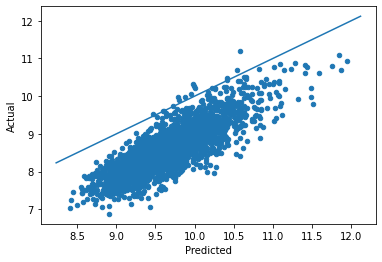

In [6]:
plot_fit('m_majority')

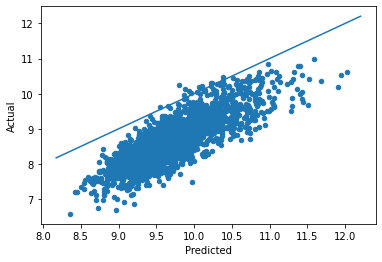

In [7]:
plot_fit('f_majority')

## Estimation

In [8]:
InputFiles = {'Expenditures':('1vAkoVklr_MZru0cdA1atOHgwMCkoFHt8EW9VN9xOeEo','Expenditures'),
              'Consumption':('1tH5gQr0iN_Ge5d8OPB8qYZS77UfZbRMppPt8iabk-ng','Consumption'),
              'HH Characteristics':('1vAkoVklr_MZru0cdA1atOHgwMCkoFHt8EW9VN9xOeEo','HH Characteristics'),
              'FCT':('1tZ2oLHUHTrw07bCaW8lUnNclMK-ivtq53ZwdBvYMDtc','03 NV_sum_39 (per 100g EP)')}

In [9]:
def get_clean_sheet(key,json_creds,sheet=None):

    df = read_sheets(key,json_creds,sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    json_creds='../students-9093fa174318.json',
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['j','t','m'])
x.columns.name = 'i'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    json_creds='../students-9093fa174318.json',
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['j','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get purchased consumption quantities
q = get_clean_sheet(InputFiles['Consumption'][0],
                    json_creds='../students-9093fa174318.json',
                    sheet=InputFiles['Consumption'][1])

if 'm' not in q.columns:
    q['m'] = 1

q = q.set_index(['j','t','m','u'])
q.columns.name = 'i'

q = q.apply(lambda x: pd.to_numeric(x,errors='coerce'))
q = q.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    json_creds='../students-9093fa174318.json',
                    sheet=InputFiles['FCT'][1])

#### This bit peculiar to Niger FCT #####
fct = fct.loc[fct.Code.str.len()==6]
fct = fct.set_index('Code')
fct.columns = [v.replace('\n',' ') for v in fct.columns]
fct.index.name = 'i'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

In [10]:
import cfe

result = cfe.Result(y=np.log(x),z=z)

# Estimates most things (not counting std errors for betas).
xhat = result.get_predicted_expenditures() 

result.get_beta(as_df=True).sort_values(ascending=False) # Check sanity...

i
Milk powder                             0.621545
Sugar                                   0.569223
Rice-local                              0.557892
Chocolate drinks                        0.541461
Rice-Imported                           0.535315
Seafood (lobster, crab, prawns)         0.528855
Agricultural eggs                       0.492709
Condiments,(salt,spices,pepper, etc)    0.414796
Fish-Dried                              0.403277
Sachet water                            0.403258
Fish-Fresh                              0.386942
White beans                             0.371580
Onions                                  0.368187
Fish-Smoked                             0.354824
Bread                                   0.346662
Soft drinks (Coca cola, spirit etc)     0.346603
Groundnut oil                           0.344536
Sweet Potatoes                          0.339676
Malt drinks                             0.338216
Tomato puree(canned)                    0.337039
Bananas           

In [11]:
result.delta.to_dataframe().unstack('k') #estimate delta

delta                                \
k                                        F 0-3   F 14-18   F 19-30   F 31-50   
i                                                                              
(Cocoyam, Spinach, etc)              -0.023781  0.027689  0.094989  0.110343   
Agricultural eggs                     0.042721  0.048770  0.098147  0.148663   
Bananas                               0.024251  0.035830  0.071993  0.100703   
Beef                                  0.006855  0.067865  0.088548  0.103018   
Beer (local and imported)             0.046941  0.016815  0.016893  0.080541   
Bread                                 0.023225  0.080997  0.096974  0.099630   
Brown beans                           0.028881  0.081007  0.078684  0.109293   
Chicken                              -0.071763 -0.004462  0.060025  0.195275   
Chocolate drinks                      0.070132  0.092243  0.165170  0.115693   
Cocoyam                              -0.046442  0.104503  0.064084  0.025710   
Condiments,(salt,spices,pepper, etc)  0.107599  0.082288  0.056840  0.112495   
Fish-Dried                           -0.020381  0.085493  0.055050  0.062076   
Fish-Fresh                           -0.094961  0.034831  0.107473  0.101196   
Fish-Frozen                           0.035798  0.048886  0.047478  0.073759   
Fish-Smoked                           0.038693  0.136282  0.040907  0.058579   
Garden eggs/egg plant                -0.034263  0.031722  0.020718  0.048421   
Gari -Yellow                         -0.032363  0.031388  0.118099  0.108256   
Gari-White                           -0.027322  0.085809  0.098735  0.125894   
Goat                                 -0.023484 -0.016799  0.107536  0.049343   
Groundnut oil                         0.016858  0.087284  0.059682  0.068239   
Malt drinks                           0.003478  0.049992  0.058493  0.078982   
Milk powder                           0.088818  0.066332  0.141524  0.126835   
Milk tinned (unsweetened)            -0.010725  0.055121  0.027428  0.039411   
Okra-fresh                            0.029346  0.065519  0.092492  0.053412   
Onions                                0.017537  0.075069  0.079954  0.062878   
Orange/tangerine                      0.049942  0.048936  0.043204  0.006788   
Other vegetables (fresh or canned)   -0.025755  0.055946  0.072081  0.028913   
Palm oil                              0.037787  0.090088  0.058209  0.075289   
Pineapples                           -0.021489 -0.014178  0.017237  0.108788   
Plantains                             0.003805  0.109790  0.057469  0.123725   
Rice-Imported                        -0.010551  0.213470  0.169883  0.154974   
Rice-local                            0.033075  0.125565  0.119137  0.084330   
Sachet water                         -0.063939  0.052499  0.064801  0.074672   
Seafood (lobster, crab, prawns)      -0.061463  0.027758  0.163717  0.058583   
Soft drinks (Coca cola, spirit etc)   0.014813  0.071592  0.062311  0.053861   
Sugar                                 0.085182  0.120536  0.128950  0.017301   
Sweet Potatoes                        0.042861  0.020470  0.063971  0.141039   
Tea                                  -0.001488  0.102052 -0.012763  0.110691   
Tomato puree(canned)                 -0.028166  0.096370  0.057285  0.086558   
Tomatoes                              0.039816  0.074168  0.087891  0.100064   
White beans                           0.013274  0.059082  0.096552  0.068464   
Yam-roots                             0.005485  0.084241  0.100080  0.097695   

                                                                              \
k                                        F 4-8     F 51+    F 9-13     M 0-3   
i                                                                              
(Cocoyam, Spinach, etc)               0.015007  0.048901  0.021452 -0.016940   
Agricultural eggs                     0.048441  0.048849  0.020054  0.034552   
Bananas                              -0.

In [12]:
result.a.to_dataframe().unstack('i') #estimate constant or the effects of prices

a                                        \
i      (Cocoyam, Spinach, etc) Agricultural eggs   Bananas      Beef   
t    m                                                                 
2010 1                4.137737          4.828057  4.752126  6.097617   
2012 1                3.889263          4.668995  4.797573  6.045537   
2015 1                4.577396          4.635355  4.870031  6.300591   
2018 1                4.542926          5.034882  5.092828  6.482760   

                                                                  \
i      Beer (local and imported)     Bread Brown beans   Chicken   
t    m                                                             
2010 1                  5.850864  5.065000    5.226534  6.381765   
2012 1                  5.887621  4.979842    5.451375  6.752976   
2015 1                  5.908671  5.361291    5.463122  6.827355   
2018 1                  5.989649  5.386449    5.861558  7.286177   

                                   ...               \
i      Chocolate drinks   Cocoyam  ... Sachet water   
t    m                             ...                
2010 1         5.264990  4.954118  ...     3.932422   
2012 1         4.891285  5.041017  ...     3.968107   
2015 1         4.937620  4.795919  ...     4.542681   
2018 1         4.897823  5.195277  ...     4.659982   

                                                                            \
i      Seafood (lobster, crab, prawns) Soft drinks (Coca cola, spirit etc)   
t    m                                                                       
2010 1                        5.415796                            4.584848   
2012 1                        5.453243                            4.612641   
2015 1                        5.428175                            4.871347   
2018 1                        5.057304                            5.212478   

                                                                          \
i          Sugar Sweet Potatoes       Tea Tomato puree(canned)  Tomatoes   
t    m                                                                     
2010 1  4.079971       4.940481  4.469507             4.097380  4.565690   
2012 1  3.787264       4.623269  4.176427             4.270221  4.574160   
2015 1  3.898006       5.022711  4.390000             4.626264  4.739670   
2018 1  4.071054       5.184641  4.521923             4.820292  4.956331   

                              
i      White beans Yam-roots  
t    m                        
2010 1    5.031474  5.717074  
2012 1    5.354511  5.818081  
2015 1    5.467301  5.998356  
2018 1    5.835745  6.287897  

[4 rows x 42 columns]

In [13]:
#infer prices

xhatdf = xhat.to_dataframe('').unstack('i')
xhatdf.columns = xhatdf.columns.droplevel(0)

phat = (xhatdf/q).squeeze()

phat = phat.xs('Kilograms',level='u').groupby(['t','m']).median().dropna(how='all')

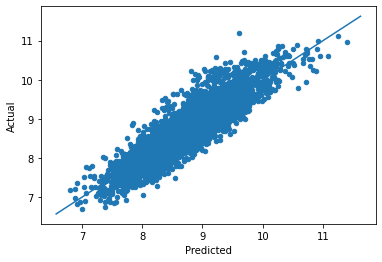

In [14]:
#Predicting Positive Consumption

zeros_r = cfe.Result(y=(0.+(result.y>0)),z=result.z)
weights = zeros_r.get_predicted_log_expenditures()

# Truncate to make weights live in [0,1]
weights = weights.where((weights<1) + np.isnan(weights),1).where((weights>0) + np.isnan(weights),0)

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()

# Calculate *expected* predicted expenditures, to make unconditional on being positive
xhat = (weights*result.get_predicted_expenditures())
xsum = xhat.sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xsum)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

In [15]:
#predicted quantities
qhat = xhat/phat.to_xarray().to_array('i')

qhat = qhat.to_dataframe('q').unstack('i')

qhat.columns = qhat.columns.droplevel(0)

In [16]:
qhat

,,i,"(Cocoyam, Spinach, etc)",Agricultural eggs,Bananas,Beef,Beer (local and imported),Bread,Brown beans,Chicken,Chocolate drinks,Cocoyam,...,Sachet water,"Seafood (lobster, crab, prawns)","Soft drinks (Coca cola, spirit etc)",Sugar,Sweet Potatoes,Tea,Tomato puree(canned),Tomatoes,White beans,Yam-roots
j,t,m,,,,,,,,,,,,,,,,,,,,,
10001,2010,1,0.223517,0.424967,1.037030,1.481580,0.374143,1.658321,1.094558,0.403695,0.525671,0.297989,...,7.312621,0.061479,1.064632,0.595568,0.643182,0.150710,0.335073,2.018080,2.177943,6.243264
10002,2010,1,0.211967,0.318948,0.965263,1.367328,0.265072,1.569283,1.051556,0.301185,0.470475,0.302951,...,6.722943,0.065886,1.008866,0.644868,0.600272,0.135888,0.303336,1.924732,2.342799,6.849040
10003,2010,1,0.115088,0.116214,0.466512,0.714681,0.131801,0.838397,0.607345,0.170603,0.131935,0.171517,...,2.749131,0.018157,0.469846,0.211149,0.294705,0.071691,0.146861,1.034554,1.147717,3.433699
10004,2010,1,0.110956,0.103114,0.426318,0.614027,0.135922,0.674259,0.532003,0.152824,0.137082,0.171136,...,2.483277,0.015400,0.412462,0.145535,0.246538,0.076894,0.147797,0.925210,0.993469,3.074342
10005,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379146,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
379148,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
379151,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#list of relevant food items
print(pd.Series(xhat.coords['i']).to_markdown())

|    | 0                                    |
|---:|:-------------------------------------|
|  0 | (Cocoyam, Spinach, etc)              |
|  1 | Agricultural eggs                    |
|  2 | Bananas                              |
|  3 | Beef                                 |
|  4 | Beer (local and imported)            |
|  5 | Bread                                |
|  6 | Brown beans                          |
|  7 | Chicken                              |
|  8 | Chocolate drinks                     |
|  9 | Cocoyam                              |
| 10 | Condiments,(salt,spices,pepper, etc) |
| 11 | Fish-Dried                           |
| 12 | Fish-Fresh                           |
| 13 | Fish-Frozen                          |
| 14 | Fish-Smoked                          |
| 15 | Garden eggs/egg plant                |
| 16 | Gari -Yellow                         |
| 17 | Gari-White                           |
| 18 | Goat                                 |
| 19 | Groundnut oil              

In [18]:
# Dictionary mapping index i to fct codes

i_to_fct = read_sheets("1PVOESM6mx57P9B_YviWOr3uizEC-KKz29WOCG2Jm7Uk",
                 sheet="Codes",
                 json_creds='../students-9093fa174318.json')

i_to_fct = i_to_fct[['Food description', 'WAFCT ID']].dropna().set_index('Food description')
i_to_fct2 = i_to_fct.loc[i_to_fct.index.isin(qhat.columns)].squeeze().to_dict()

# Create version of qhat with fct ids for labels
myq = qhat.rename(columns=i_to_fct2)[list(i_to_fct2.values())]

# # Drop goods with no obs, households with no goods
myq = myq.dropna(how='all',axis=1).dropna(how='all')

# # Create version of fct with just foods in myq
myfct = fct.loc[fct.index.isin(myq.columns)].iloc[:,8:] # Drop columns which aren't nutrients

In [19]:
myq = myq[['01_046',
 '01_065',
 '01_037',
 '02_039',
 '02_005',
 '02_042',
 '02_049',
 '02_034',
 '03_022',
 '03_057',
 '04_012',
 '04_017',
 '04_018',
 '04_066',
 '04_021',
 '05_048',
 '05_016',
 '05_018',
 '07_014',
 '07_030',
 '07_069',
 '08_001',
 '09_021',
 '09_053',
 '10_016',
 '10_002',
 '11_003',
 '11_007',
 '12_001',
 '12_003',
 '12_024',
 '12_008',
 '12_019',
 '13_002',
 '13_021']]
myq = myq.loc[:,~myq.columns.duplicated()]

In [20]:
#Map predicted quantities into nutrients
nutrients = myq@myfct
nutrients.mean()  # NB: Nutrients are for past /week/ for entire household.

Protein, total (g)                                                                                                                 NaN
Fat, total or [fat, derived by analysis using continuous extraction] (g)                                                           NaN
Carbohydrate, available; calculated by difference (g)                                                                       685.325514
Fibre, total dietary or [fibre, crude] (g)                                                                                         NaN
Ash (g)                                                                                                                            NaN
Calcium (mg)                                                                                                               1145.366127
Iron (mg)                                                                                                                          NaN
Magnesium (mg)                                         